# PetFinder.my

In [1]:
import json
import os
import pickle

import keras.utils
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
from keras.applications import Xception
from keras.callbacks import ModelCheckpoint
from keras.layers import Input, Activation, Flatten, Dense
from keras.layers import (concatenate)
from keras.models import Model
from keras.models import load_model
from keras.optimizers import Adam
from skimage.transform import resize
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, cohen_kappa_score
from sklearn.model_selection import train_test_split
from tqdm import tqdm
%matplotlib inline

data_dir = "C:\\Users\\Priit\\Dropbox\\Informaatika\\Magister\\Tehisnärvivõrgud\\data"

sentiment_train_dir =  os.path.join(data_dir, "train_sentiment") 
sentiment_test_dir =  os.path.join(data_dir, "test_sentiment") 

train_image = os.path.join(data_dir, "train_images")
test_image = os.path.join(data_dir, "test_images")

label_column = "AdoptionSpeed"

BATCH_SIZE, test_size = 512, 0.2

height, width = 100, 100

Using TensorFlow backend.


# Data processing
### Helper functions for data processing

In [2]:
def read_csv_kaggle(path, is_train, train_data=None):
    train = pd.read_csv(path, sep=',')
    pet_ids = train["PetID"]

    selected_columns = ["Type",
                        "Gender",
                        "Color1",
                        "Color2",
                        "Color3",
                        "MaturitySize",
                        "FurLength",
                        "Vaccinated",
                        "Dewormed",
                        "Sterilized",
                        "Health",
                        #"State",
                        "MaturitySize"]
    
    y = train[label_column] if is_train else None
    
    # One-Hot-encode
    X = pd.get_dummies(train[selected_columns], columns=selected_columns)

    # Normalize:
    to_normalize = ["Age", "Fee", "Quantity", "PhotoAmt"]
    
    if is_train:
        for to_norm in to_normalize:
             X[to_norm] = (train[to_norm] - train[to_norm].mean()) / train[to_norm].std()
    else:
        train_data = pd.read_csv(train_data, sep=',')
        for to_norm in to_normalize:
             X[to_norm] = (train[to_norm] - train_data[to_norm].mean()) / train_data[to_norm].std()
        
    
    return X, y, pet_ids

def read_images(image_paths):
    def random_image():
        return np.random.rand(height, width, 3) * 255
    
    def read_image(path):
        img = np.asarray(Image.open(path).convert("RGB"), dtype="int32" )
        return resize(img, (height, width), anti_aliasing=True, mode='constant')    

    return np.array([read_image(path) if os.path.isfile(path) else random_image() for path in tqdm(image_paths)])

def read_sentiment(pet_ids, sentiment_paths):
    magnitudes, scores = [], []
    
    for pet_id in tqdm(pet_ids):
        file_loc = os.path.join(sentiment_paths, "{}.json".format(pet_id))
        # check if there exists sentiment analysis for the pet, else set scores 0.0
        if os.path.isfile(file_loc):
            with open(file_loc, encoding="UTF-8", mode="r") as json_file:  
                data = json.load(json_file)
                magnitude,score = data["documentSentiment"]["magnitude"], data["documentSentiment"]["score"]
        else:
            magnitude, score = 0.0, 0.0
    
        magnitudes.append(magnitude)
        scores.append(score)
    return magnitudes, scores
    

### Read training CSV

In [3]:
X, y, pet_ids = read_csv_kaggle(os.path.join(data_dir, "train.csv"), True)
X["sent_magnitude"], X["sent_score"] = read_sentiment(pet_ids, sentiment_train_dir)

100%|███████████████████████████████████████████████████████████████████████████| 14993/14993 [00:21<00:00, 697.24it/s]


### Read training images

In [4]:
f_im_name = "images.binary"

if not os.path.isfile(f_im_name):
    images = read_images([os.path.join(train_image, pet_id + "-1.jpg") for pet_id in pet_ids])
    
    # Standardize:
    mean, std = np.mean(images), np.std(images)
    images_meanstd = (images - mean)/std
    
    with open(f_im_name, 'wb') as handle_1, open("mnstd", 'wb') as handle_2:
        pickle.dump(images_meanstd, handle_1, protocol=pickle.HIGHEST_PROTOCOL)        
        pickle.dump((mean, std), handle_2, protocol=pickle.HIGHEST_PROTOCOL)

else:
    with open(f_im_name, 'rb') as handle_1, open("mnstd", 'rb') as handle_2:
        images_meanstd = pickle.load(handle_1)
        temp = pickle.load(handle_2)
        mean, std = temp[0], temp[1]
                
print(images_meanstd.shape)

(14993, 100, 100, 3)


### Split traint/test

In [5]:
X_train_img, X_test_img, X_train_else, X_test_else, y_train, y_test = train_test_split(images_meanstd, 
                                                                                       X, 
                                                                                       y, 
                                                                                       test_size=test_size,
                                                                                       random_state=1)

# Create & train models

### Baseline model

In [6]:
rf = RandomForestClassifier(n_estimators=65, max_depth=15)
rf.fit(X_train_else, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=15, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=65, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

### Neural Net solution

In [7]:
# https://stackoverflow.com/questions/49618986/neural-network-in-keras-with-two-different-input-types-images-and-values
# https://www.learnopencv.com/keras-tutorial-transfer-learning-using-pre-trained-models/

transfer = Xception(weights='imagenet', include_top=False, input_shape=(height, width, 3))

# Freeze Xception
for layer in transfer.layers[:-3]:
    layer.trainable = False

# Inputs
image_input = Input(shape=(height, width, 3))
aux_input = Input(shape=(len(list(X_train_else)),))

# Images:
transfer = transfer(image_input)
flatten = Flatten()(transfer)

# Aux input:
x = Dense(250, activation='relu')(aux_input)
x = Dense(350, activation='relu')(x)
x = Dense(450, activation='relu')(x)
x = Dense(700, activation='relu')(x)

# Merged:
merge = concatenate([flatten, x])
x = Dense(100, activation='relu')(merge)
h = Dense(5, activation='relu')(x)

# Predictions:
predictions = Activation('softmax')(h)

model = Model(inputs=[image_input, aux_input], outputs=predictions)
model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


history = model.fit([X_train_img, X_train_else], 
                    keras.utils.to_categorical(y_train),
                    batch_size=BATCH_SIZE, 
                    epochs=4, 
                    validation_split=0.1,
                    callbacks=[ModelCheckpoint('test_model.h5', save_best_only=True)])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 10794 samples, validate on 1200 samples
Epoch 1/4
10794/10794 [==============================] - ETA: 34:07 - loss: 1.6176 - acc: 0.15 - ETA: 30:42 - loss: 1.6414 - acc: 0.19 - ETA: 28:35 - loss: 1.6548 - acc: 0.20 - ETA: 26:54 - loss: 1.6640 - acc: 0.22 - ETA: 25:09 - loss: 1.6516 - acc: 0.23 - ETA: 23:31 - loss: 1.6615 - acc: 0.24 - ETA: 21:51 - loss: 1.6407 - acc: 0.24 - ETA: 20:14 - loss: 1.6273 - acc: 0.25 - ETA: 18:44 - loss: 1.6150 - acc: 0.26 - ETA: 17:12 - loss: 1.6105 - acc: 0.26 - ETA: 15:38 - loss: 1.6053 - acc: 0.26 - ETA: 14:05 - loss: 1.6113 - acc: 0.26 - ETA: 12:31 - loss: 1.6071 - acc: 0.26 - ETA: 10:59 - loss: 1.6001 - acc: 0.27 - ETA: 9:25 - loss: 1.6029 - acc: 0.2755 - ETA: 7:52 - loss: 1.6003 - acc: 0.279 - ETA: 6:18 - loss: 1.5921 - acc: 0.281 - ETA: 4:46 - loss: 1.5937 - acc: 0.284 - ETA: 3:13 - loss: 1.5961 - acc: 0.287 - ETA: 1:40 - l

Text(0.5, 1.0, 'Accuracy')

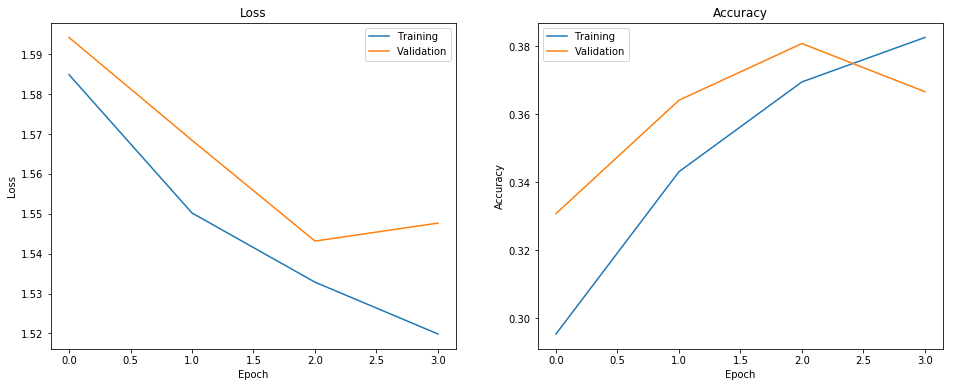

In [8]:
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training', 'Validation'])
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training', 'Validation'])
plt.title('Accuracy')

# Evaluate models

## Neural Net

In [9]:
train_pred = [np.argmax(pred) for pred in model.predict([X_train_img, X_train_else])]
test_predictions = [np.argmax(pred) for pred in model.predict([X_test_img, X_test_else])]

In [10]:
print("Kappa on train: {}".format(round(cohen_kappa_score(y_train, train_pred, weights="quadratic"), 4)))
print("Accuracy on train: {}".format(round(accuracy_score(y_train, train_pred), 4)))
print("________________")
print("Kappa on test: {}".format(round(cohen_kappa_score(y_test, test_predictions, weights="quadratic"), 4)))
print("Accuracy on test: {}".format(round(accuracy_score(y_test, test_predictions), 4)))

Kappa on train: 0.295
Accuracy on train: 0.3864
________________
Kappa on test: 0.2389
Accuracy on test: 0.3521


## Baseline

In [11]:
train_pred = [pred for pred in rf.predict(X_train_else)]
test_predictions = [pred for pred in rf.predict(X_test_else)]

print("Kappa on train: {}".format(round(cohen_kappa_score(y_train, train_pred, weights="quadratic"), 4)))
print("Accuracy on train: {}".format(round(accuracy_score(y_train, train_pred), 4)))
print("________________")
print("Kappa on test: {}".format(round(cohen_kappa_score(y_test, test_predictions, weights="quadratic"), 4)))
print("Accuracy on test: {}".format(round(accuracy_score(y_test, test_predictions), 4)))

Kappa on train: 0.8177
Accuracy on train: 0.8548
________________
Kappa on test: 0.2746
Accuracy on test: 0.3741


## Kaggle Test

In [12]:
test, _, test_pet_ids = read_csv_kaggle(os.path.join(data_dir, "test.csv"), False, os.path.join(data_dir, "train.csv"))
test["sent_magnitude"], test["sent_score"] = read_sentiment(test_pet_ids, sentiment_test_dir)
test_images = read_images([os.path.join(test_image, pet_id + "-1.jpg") for pet_id in test_pet_ids])
test_images_std = (test_images - mean)/std

100%|██████████████████████████████████████████████████████████████████████████████| 3972/3972 [01:37<00:00, 40.56it/s]


### Neural Net

In [13]:
loaded = load_model('test_model.h5')
test_pred = loaded.predict([test_images_std, test])
test_pred_label = [np.argmax(pred) for pred in test_pred]
pd.DataFrame({'PetID': test_pet_ids, 'AdoptionSpeed': test_pred_label}).to_csv('neural.csv', index=False)

### Baseline

In [14]:
pd.DataFrame({'PetID': test_pet_ids, 'AdoptionSpeed': rf.predict(test)}).to_csv('baseline.csv', index=False)